# ベースモデル（LSTM）
## 特徴量：client, close, price_am, price_pm

## 注意点
・使用しているデータは2011年4月1日以降のデータです\
・使った特徴量は上記の4つのみです\
・前処理は何もしていません\
・Trainデータの中から、時系列的に最後の1割を検証用データとして切り離しています

検証データについては以下のQ＆Aが参考になります。\
https://datascience.stackexchange.com/questions/109066/validation-split-in-time-series-data-for-lstm-model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install japanize_matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
sns.set()

from datetime import date
import holidays
import datetime as dt
import japanize_matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.1 MB 6.0 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=f1e2d741488e05ff8fb3276c275b7bb966cccf512c7f61d3a60555c632254c14
  Stored in directory: /root/.cache/pip/wheels/4f/ca/96/4cc5e192421cceb077fbf4ffec533382edd416fd3fa0af0bbd
Successfully built japanize-matplotlib


In [3]:
data = pd.read_csv("/content/drive/MyDrive/LSTMの実装：引越し需要予測/after_cluster_1219.csv")
data.head()

,Unnamed: 0,Unnamed: 0.1,datetime,y,client,close,price_am,price_pm,year,month,day,Weekday,holidays,new_data_am,new_data_pm,ampm_diff,cluster
0,274,274,2011-04-01,48,0,0,4,2,2011,4,1,Friday,0,0.935798,0.562071,0.748934,1
1,275,275,2011-04-02,29,0,0,5,4,2011,4,2,Saturday,0,1.000000,1.111745,1.055872,1
2,276,276,2011-04-03,28,0,0,3,3,2011,4,3,Sunday,0,0.740179,0.851252,0.795715,1
3,277,277,2011-04-04,23,0,0,2,1,2011,4,4,Monday,0,0.438909,0.295521,0.367215,1
4,278,278,2011-04-05,25,0,0,1,1,2011,4,5,Tuesday,0,0.239600,0.295521,0.267561,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    1827 non-null   int64  
 1   Unnamed: 0.1  1827 non-null   int64  
 2   datetime      1827 non-null   object 
 3   y             1827 non-null   int64  
 4   client        1827 non-null   int64  
 5   close         1827 non-null   int64  
 6   price_am      1827 non-null   int64  
 7   price_pm      1827 non-null   int64  
 8   year          1827 non-null   int64  
 9   month         1827 non-null   int64  
 10  day           1827 non-null   int64  
 11  Weekday       1827 non-null   object 
 12  holidays      1827 non-null   int64  
 13  new_data_am   1827 non-null   float64
 14  new_data_pm   1827 non-null   float64
 15  ampm_diff     1827 non-null   float64
 16  cluster       1827 non-null   int64  
dtypes: float64(3), int64(12), object(2)
memory usage: 242.8+ KB


In [5]:
data.query('client == 1')

,Unnamed: 0,Unnamed: 0.1,datetime,y,client,close,price_am,price_pm,year,month,day,Weekday,holidays,new_data_am,new_data_pm,ampm_diff,cluster
1145,1419,1419,2014-05-20,19,1,0,0,0,2014,5,20,Tuesday,0,0.000000,0.000000,0.000000,0
1170,1444,1444,2014-06-14,45,1,0,1,1,2014,6,14,Saturday,0,0.239600,0.295521,0.267561,0
1196,1470,1470,2014-07-10,30,1,0,0,0,2014,7,10,Thursday,0,0.000000,0.000000,0.000000,0
1205,1479,1479,2014-07-19,41,1,0,2,1,2014,7,19,Saturday,0,0.438909,0.295521,0.367215,0
1209,1483,1483,2014-07-23,40,1,0,0,0,2014,7,23,Wednesday,0,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822,2096,2096,2016-03-27,94,1,0,5,4,2016,3,27,Sunday,0,1.000000,1.111745,1.055872,0
1823,2097,2097,2016-03-28,86,1,0,4,4,2016,3,28,Monday,0,0.935798,1.111745,1.023771,0
1824,2098,2098,2016-03-29,98,1,0,4,4,2016,3,29,Tuesday,0,0.935798,1.111745,1.023771,0
1825,2099,2099,2016-03-30,99,1,0,5,4,2016,3,30,Wednesday,0,1.000000,1.111745,1.055872,0


In [6]:
# 0	datetime	日時（YYYY-MM-DD）	文字列
# 1	y	引越し数	数値：整数
# 2	client	法人が絡む特殊な引越し日フラグ	数値：整数（0,1）
# 3	close	休業日	数値：整数（0,1）
# 4	price_am	午前の料金区分（-1は欠損を表す。5が最も料金が高い）	数値：整数（-1,0,1,2,3,4,5）
# 5	price_pm	午後の料金区分（-1は欠損を表す。5が最も料金が高い）	数値：整数（-1,0,1,2,3,4,5）

In [7]:
#datetimeを日付型に変換
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')

In [8]:
# data['year'] = data['datetime'].dt.year
# data['month'] = data['datetime'].dt.month
# data['day'] = data['datetime'].dt.day
# data['Weekday'] = data['datetime'].dt.strftime('%A')

In [9]:
# Week_dayをラベルエンコーディング
from sklearn.preprocessing import LabelEncoder
data["Weekday"] = LabelEncoder().fit_transform(data["Weekday"])

## モデル実装

In [10]:
!pip3 install keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 学習データの作成

In [11]:
# 2011年４月１日以降のデータを対象にしてベースモデルを作成する
data = data[data["datetime"] >= "2011-04-01" ]



In [12]:
# 再現性の確保のために乱数シードを固定
tf.random.set_seed(12345)

In [13]:
#データセットを作る関数
look_back = 30


def make_dataset(raw_data, look_back=30):
    _x = []
    _y = []

    for i in range(len(raw_data) - look_back):
        _x.append(raw_data[i : i + look_back])
        _y.append(raw_data[i + look_back])
    _x = np.array(_x).reshape(len(_x), look_back, 1)
    _y = np.array(_y).reshape(len(_y), 1)

    return _x, _y

In [14]:
X_y, y_y = make_dataset(data['y'].values, look_back=look_back)
X_client, y_client = make_dataset(data['client'].values, look_back=look_back)
X_close, y_close = make_dataset(data['close'].values, look_back=look_back)
X_price_am, y_price_am = make_dataset(data['price_am'].values, look_back=look_back)
X_price_pm, y_price_pm = make_dataset(data['price_pm'].values, look_back=look_back)
X_holidays, y_holidays = make_dataset(data['holidays'].values, look_back=look_back)
X_Weekday, y_Weekday = make_dataset(data['Weekday'].values, look_back=look_back)
X_cluster , y_cluster = make_dataset(data["cluster"].values , look_back = look_back)

#入力データをまとめる
X_con = np.concatenate([X_client, X_close, X_price_am, X_price_pm ], axis=2)

In [15]:
X = X_con
y = y_y

sample_size = len(data) - look_back
past_size = int(sample_size * 0.90) #サンプルデータのうち、9割を学習データ、1割を検証用データとする
future_size = sample_size - past_size + 1

#データを訓練用と検証用に分割
X_past = X[:past_size]
X_future = X[past_size-1:]
y_past = y[:past_size]
y_future = y[past_size-1:]

#訓練用データを定義
X_train = X_past
y_train = y_past

## モデル構築

In [16]:
2#　モデル構築

# 1つの学習データのStep数（今回は30）

lengh_of_sequence = X_train.shape[1] 
out_nerons = 1
n_hidden = 50 #隠れ層のユニット数（数が多いほど学習モデルの複雑さが増加）
loss = tf.keras.losses.MeanAbsoluteError() # 最小絶対値誤差

model = Sequential()
model.add(LSTM(n_hidden,
               batch_input_shape=(None,lengh_of_sequence , 4) ,  #入力データの次元数
               return_sequences=False)) # バッチ型で学習するならここはFalse

model.add(Dense(out_nerons)) # 30のデータから１つの値を予測したいので１となる
model.add(Activation("linear")) # 活性化関数を指示

# compileで誤差関数：最小二乗誤差、最適化手法：Adamを用いるように定義
optimizer = Adam(lr=0.005)
model.compile(loss=loss , optimizer=optimizer)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## ベースモデル

In [17]:
# ベースモデル

early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
model.fit(X_train, y_train,
          batch_size=100,
          epochs=100, #繰り返し回数, エポック数を増やせばlossが減るのは当たり前ですが、一旦200にします。
          validation_data=[X_future, y_future] #検証用のデータを明示的に指定できる
          )

Epoch 1/100
17/17 [==============================] - 4s 105ms/step - loss: 30.4426 - val_loss: 38.8000
Epoch 2/100
17/17 [==============================] - 1s 54ms/step - loss: 23.1192 - val_loss: 33.7408
Epoch 3/100
17/17 [==============================] - 1s 56ms/step - loss: 19.2418 - val_loss: 29.6233
Epoch 4/100
17/17 [==============================] - 1s 51ms/step - loss: 16.4409 - val_loss: 26.3275
Epoch 5/100
17/17 [==============================] - 1s 55ms/step - loss: 14.6775 - val_loss: 23.8251
Epoch 6/100
17/17 [==============================] - 1s 59ms/step - loss: 13.6401 - val_loss: 22.1059
Epoch 7/100
17/17 [==============================] - 1s 62ms/step - loss: 13.0712 - val_loss: 20.8945
Epoch 8/100
17/17 [==============================] - 1s 62ms/step - loss: 12.8170 - val_loss: 20.1190
Epoch 9/100
17/17 [==============================] - 1s 57ms/step - loss: 12.7321 - val_loss: 19.7097
Epoch 10/100
17/17 [==============================] - 1s 58ms/step - loss: 12.693

In [18]:
# 予測
predictions = model.predict(X_past)
future_predictions = model.predict(X_future)


6/6 [==============================] - 0s 6ms/step


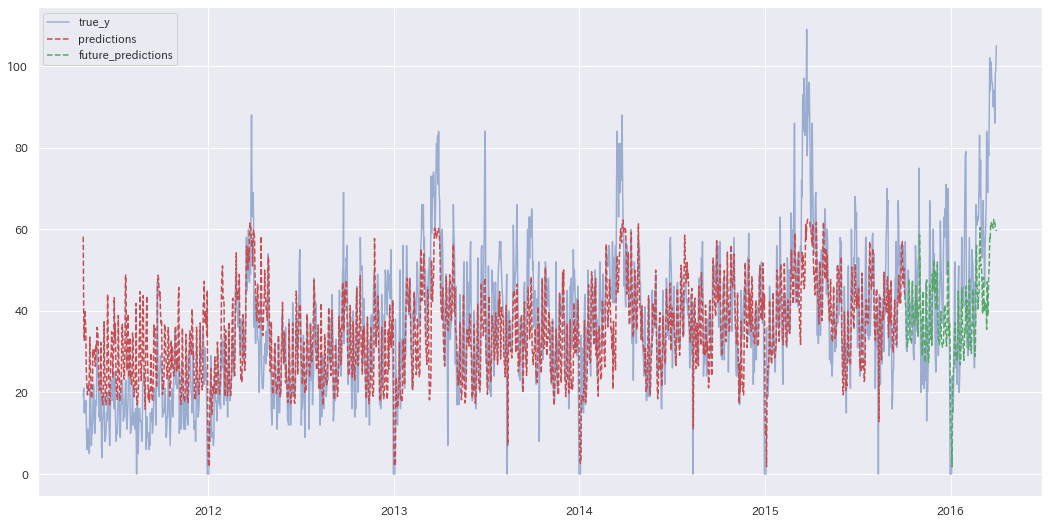

In [19]:
#可視化
plt.figure(figsize=(18,9))
plt.plot(data['datetime'][look_back:], y, color='b', label='true_y', alpha = 0.5)
plt.plot(data['datetime'][look_back:look_back + past_size], predictions, color='r', linestyle='dashed', label='predictions')
plt.plot(data['datetime'][-future_size:], future_predictions, color='g', linestyle='dashed', label='future_predictions')
plt.legend()
plt.show()

赤色が訓練データに対する予測のプロット、\
緑色が検証データに対する予測のプロットです。\


In [20]:
from sklearn.metrics import mean_absolute_error

print('訓練データに対するMAE:', mean_absolute_error(y_past, predictions))
print('検証データに対するMAE:', mean_absolute_error(y_future, future_predictions))


訓練データに対するMAE: 8.597127646447408
検証データに対するMAE: 14.142436898874314


In [21]:
# epoc200の場合
# 訓練データに対するMAE: 4.918429925475654
# 検証データに対するMAE: 15.056553137236538

In [22]:
# epoc100の場合
# 訓練データに対するMAE: 9.48821008891033
# 検証データに対するMAE: 13.347625901027278


In [23]:
data.head()

,Unnamed: 0,Unnamed: 0.1,datetime,y,client,close,price_am,price_pm,year,month,day,Weekday,holidays,new_data_am,new_data_pm,ampm_diff,cluster
0,274,274,2011-04-01,48,0,0,4,2,2011,4,1,0,0,0.935798,0.562071,0.748934,1
1,275,275,2011-04-02,29,0,0,5,4,2011,4,2,2,0,1.000000,1.111745,1.055872,1
2,276,276,2011-04-03,28,0,0,3,3,2011,4,3,3,0,0.740179,0.851252,0.795715,1
3,277,277,2011-04-04,23,0,0,2,1,2011,4,4,1,0,0.438909,0.295521,0.367215,1
4,278,278,2011-04-05,25,0,0,1,1,2011,4,5,5,0,0.239600,0.295521,0.267561,1


## ベースモデル⇨新たなprice指標を追加

Epoch 1/100


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


17/17 [==============================] - 5s 71ms/step - loss: 31.5758 - val_loss: 39.2180
Epoch 2/100
17/17 [==============================] - 0s 28ms/step - loss: 23.3215 - val_loss: 33.8668
Epoch 3/100
17/17 [==============================] - 0s 27ms/step - loss: 19.3271 - val_loss: 29.7093
Epoch 4/100
17/17 [==============================] - 0s 28ms/step - loss: 16.4934 - val_loss: 26.3898
Epoch 5/100
17/17 [==============================] - 0s 26ms/step - loss: 14.7055 - val_loss: 23.8630
Epoch 6/100
17/17 [==============================] - 0s 28ms/step - loss: 13.6537 - val_loss: 22.1241
Epoch 7/100
17/17 [==============================] - 0s 25ms/step - loss: 13.0769 - val_loss: 20.9093
Epoch 8/100
17/17 [==============================] - 0s 27ms/step - loss: 12.8210 - val_loss: 20.1341
Epoch 9/100
17/17 [==============================] - 0s 26ms/step - loss: 12.7349 - val_loss: 19.7252
Epoch 10/100
17/17 [==============================] - 0s 27ms/step - loss: 12.6955 - val_loss:

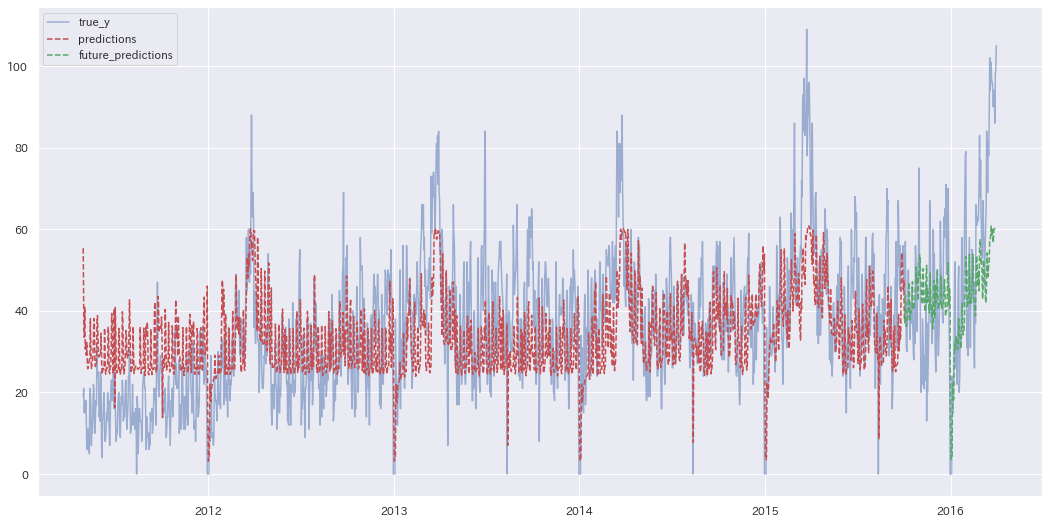

In [24]:
X_y, y_y = make_dataset(data['y'].values, look_back=look_back)
X_client, y_client = make_dataset(data['client'].values, look_back=look_back)
X_close, y_close = make_dataset(data['close'].values, look_back=look_back)
X_price_am, y_price_am = make_dataset(data['price_am'].values, look_back=look_back)
X_price_pm, y_price_pm = make_dataset(data['price_pm'].values, look_back=look_back)
X_holidays, y_holidays = make_dataset(data['holidays'].values, look_back=look_back)
X_Weekday, y_Weekday = make_dataset(data['Weekday'].values, look_back=look_back)
X_cluster , y_cluster = make_dataset(data["cluster"].values , look_back = look_back)
X_new_price  , y_new_price = make_dataset(data["ampm_diff"].values , look_back = look_back)

#入力データをまとめる
X_con = np.concatenate([X_client, X_close, X_new_price ], axis=2)

X = X_con
y = y_y

sample_size = len(data) - look_back
past_size = int(sample_size * 0.90) #サンプルデータのうち、9割を学習データ、1割を検証用データとする
future_size = sample_size - past_size + 1

#データを訓練用と検証用に分割
X_past = X[:past_size]
X_future = X[past_size-1:]
y_past = y[:past_size]
y_future = y[past_size-1:]

#訓練用データを定義
X_train = X_past
y_train = y_past

#　モデル構築

# 1つの学習データのStep数（今回は30）

lengh_of_sequence = X_train.shape[1] 
out_nerons = 1
n_hidden = 50 #隠れ層のユニット数（数が多いほど学習モデルの複雑さが増加）
loss = tf.keras.losses.MeanAbsoluteError() # 最小絶対値誤差

model = Sequential()
model.add(LSTM(n_hidden,
               batch_input_shape=(None,lengh_of_sequence , 3) ,  #入力データの次元数
               return_sequences=False)) # バッチ型で学習するならここはFalse

model.add(Dense(out_nerons)) # 30のデータから１つの値を予測したいので１となる
model.add(Activation("linear")) # 活性化関数を指示

# compileで誤差関数：最小二乗誤差、最適化手法：Adamを用いるように定義
optimizer = Adam(lr=0.005)
model.compile(loss=loss , optimizer=optimizer)

# ベースモデル⇨epocs=100にした

early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
model.fit(X_train, y_train,
          batch_size=100,
          epochs=100, #繰り返し回数, エポック数を増やせばlossが減るのは当たり前ですが、一旦200にします。
          validation_data=[X_future, y_future] #検証用のデータを明示的に指定できる
          )


# 予測
predictions = model.predict(X_past)
future_predictions = model.predict(X_future)

#可視化
plt.figure(figsize=(18,9))
plt.plot(data['datetime'][look_back:], y, color='b', label='true_y', alpha = 0.5)
plt.plot(data['datetime'][look_back:look_back + past_size], predictions, color='r', linestyle='dashed', label='predictions')
plt.plot(data['datetime'][-future_size:], future_predictions, color='g', linestyle='dashed', label='future_predictions')
plt.legend()
plt.show()


In [25]:
print('訓練データに対するMAE:', mean_absolute_error(y_past, predictions))
print('検証データに対するMAE:', mean_absolute_error(y_future, future_predictions))

訓練データに対するMAE: 10.447111646850388
検証データに対するMAE: 13.155172474476514


## ベースモデル⇨new_price,cluster追加

In [26]:
data.head()

,Unnamed: 0,Unnamed: 0.1,datetime,y,client,close,price_am,price_pm,year,month,day,Weekday,holidays,new_data_am,new_data_pm,ampm_diff,cluster
0,274,274,2011-04-01,48,0,0,4,2,2011,4,1,0,0,0.935798,0.562071,0.748934,1
1,275,275,2011-04-02,29,0,0,5,4,2011,4,2,2,0,1.000000,1.111745,1.055872,1
2,276,276,2011-04-03,28,0,0,3,3,2011,4,3,3,0,0.740179,0.851252,0.795715,1
3,277,277,2011-04-04,23,0,0,2,1,2011,4,4,1,0,0.438909,0.295521,0.367215,1
4,278,278,2011-04-05,25,0,0,1,1,2011,4,5,5,0,0.239600,0.295521,0.267561,1


Epoch 1/100


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


17/17 [==============================] - 3s 71ms/step - loss: 30.6071 - val_loss: 39.3034
Epoch 2/100
17/17 [==============================] - 1s 31ms/step - loss: 23.5226 - val_loss: 34.1772
Epoch 3/100
17/17 [==============================] - 1s 30ms/step - loss: 19.6020 - val_loss: 30.0756
Epoch 4/100
17/17 [==============================] - 1s 31ms/step - loss: 16.6789 - val_loss: 26.5477
Epoch 5/100
17/17 [==============================] - 1s 30ms/step - loss: 14.7591 - val_loss: 23.8969
Epoch 6/100
17/17 [==============================] - 1s 31ms/step - loss: 13.6556 - val_loss: 22.0993
Epoch 7/100
17/17 [==============================] - 0s 25ms/step - loss: 13.0646 - val_loss: 20.8529
Epoch 8/100
17/17 [==============================] - 0s 26ms/step - loss: 12.8084 - val_loss: 20.0669
Epoch 9/100
17/17 [==============================] - 0s 25ms/step - loss: 12.7278 - val_loss: 19.6730
Epoch 10/100
17/17 [==============================] - 0s 26ms/step - loss: 12.6921 - val_loss:

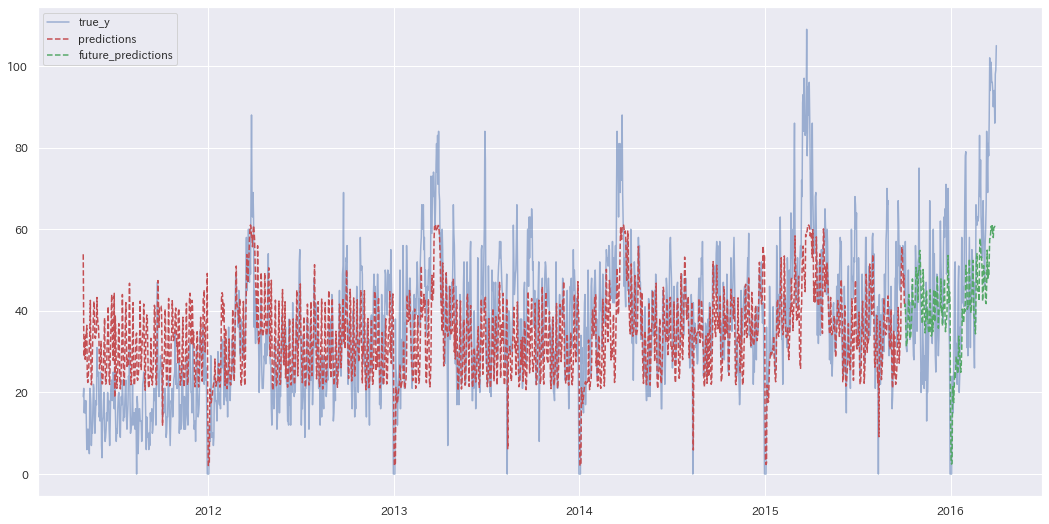

In [27]:
X_y, y_y = make_dataset(data['y'].values, look_back=look_back)
X_client, y_client = make_dataset(data['client'].values, look_back=look_back)
X_close, y_close = make_dataset(data['close'].values, look_back=look_back)
X_price_am, y_price_am = make_dataset(data['price_am'].values, look_back=look_back)
X_price_pm, y_price_pm = make_dataset(data['price_pm'].values, look_back=look_back)
X_holidays, y_holidays = make_dataset(data['holidays'].values, look_back=look_back)
X_Weekday, y_Weekday = make_dataset(data['Weekday'].values, look_back=look_back)
X_new_price  , y_new_price = make_dataset(data["ampm_diff"].values , look_back = look_back)
X_cluster , y_cluster = make_dataset(data["cluster"].values , look_back = look_back)

#入力データをまとめる
X_con = np.concatenate([X_client, X_close, X_new_price ,X_cluster], axis=2)

X = X_con
y = y_y

sample_size = len(data) - look_back
past_size = int(sample_size * 0.90) #サンプルデータのうち、9割を学習データ、1割を検証用データとする
future_size = sample_size - past_size + 1

#データを訓練用と検証用に分割
X_past = X[:past_size]
X_future = X[past_size-1:]
y_past = y[:past_size]
y_future = y[past_size-1:]

#訓練用データを定義
X_train = X_past
y_train = y_past

#　モデル構築

# 1つの学習データのStep数（今回は30）

lengh_of_sequence = X_train.shape[1] 
out_nerons = 1
n_hidden = 50 #隠れ層のユニット数（数が多いほど学習モデルの複雑さが増加）
loss = tf.keras.losses.MeanAbsoluteError() # 最小絶対値誤差

model = Sequential()
model.add(LSTM(n_hidden,
               batch_input_shape=(None,lengh_of_sequence , 4) ,  #入力データの次元数
               return_sequences=False)) # バッチ型で学習するならここはFalse



model.add(Dense(out_nerons)) # 30のデータから１つの値を予測したいので１となる
model.add(Activation("linear")) # 活性化関数を指示

# compileで誤差関数：最小二乗誤差、最適化手法：Adamを用いるように定義
optimizer = Adam(lr=0.005)
model.compile(loss=loss , optimizer=optimizer)

# ベースモデル⇨epocs=100にした

early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
model.fit(X_train, y_train,
          batch_size=100,
          epochs=100, #繰り返し回数, エポック数を増やせばlossが減るのは当たり前ですが、一旦200にします。
          validation_data=[X_future, y_future] #検証用のデータを明示的に指定できる
          )


# 予測
predictions = model.predict(X_past)
future_predictions = model.predict(X_future)

#可視化
plt.figure(figsize=(18,9))
plt.plot(data['datetime'][look_back:], y, color='b', label='true_y', alpha = 0.5)
plt.plot(data['datetime'][look_back:look_back + past_size], predictions, color='r', linestyle='dashed', label='predictions')
plt.plot(data['datetime'][-future_size:], future_predictions, color='g', linestyle='dashed', label='future_predictions')
plt.legend()
plt.show()

In [28]:
print('訓練データに対するMAE:', mean_absolute_error(y_past, predictions))
print('検証データに対するMAE:', mean_absolute_error(y_future, future_predictions))

訓練データに対するMAE: 10.132864572416505
検証データに対するMAE: 13.296419926111211


## ベースモデル⇨new_price,cluster,holidays追加

Epoch 1/100


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


17/17 [==============================] - 4s 84ms/step - loss: 31.4010 - val_loss: 39.8493
Epoch 2/100
17/17 [==============================] - 1s 47ms/step - loss: 23.9777 - val_loss: 34.7211
Epoch 3/100
17/17 [==============================] - 1s 45ms/step - loss: 20.0705 - val_loss: 30.7323
Epoch 4/100
17/17 [==============================] - 1s 44ms/step - loss: 17.1976 - val_loss: 27.3224
Epoch 5/100
17/17 [==============================] - 1s 43ms/step - loss: 15.1669 - val_loss: 24.5097
Epoch 6/100
17/17 [==============================] - 1s 46ms/step - loss: 13.9022 - val_loss: 22.5531
Epoch 7/100
17/17 [==============================] - 1s 34ms/step - loss: 13.1899 - val_loss: 21.1517
Epoch 8/100
17/17 [==============================] - 0s 26ms/step - loss: 12.8606 - val_loss: 20.2773
Epoch 9/100
17/17 [==============================] - 0s 26ms/step - loss: 12.7523 - val_loss: 19.8091
Epoch 10/100
17/17 [==============================] - 0s 27ms/step - loss: 12.7032 - val_loss:

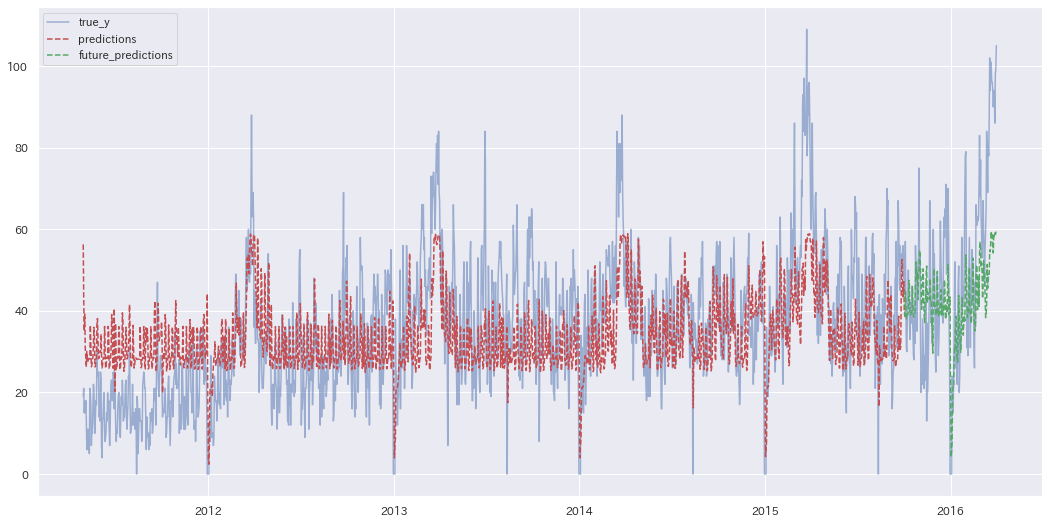

In [29]:
X_y, y_y = make_dataset(data['y'].values, look_back=look_back)
X_client, y_client = make_dataset(data['client'].values, look_back=look_back)
X_close, y_close = make_dataset(data['close'].values, look_back=look_back)
X_price_am, y_price_am = make_dataset(data['price_am'].values, look_back=look_back)
X_price_pm, y_price_pm = make_dataset(data['price_pm'].values, look_back=look_back)
X_holidays, y_holidays = make_dataset(data['holidays'].values, look_back=look_back)
X_Weekday, y_Weekday = make_dataset(data['Weekday'].values, look_back=look_back)
X_new_price  , y_new_price = make_dataset(data["ampm_diff"].values , look_back = look_back)
X_cluster , y_cluster = make_dataset(data["cluster"].values , look_back = look_back)

#入力データをまとめる
X_con = np.concatenate([X_client, X_close, X_new_price ,X_cluster , X_holidays], axis=2)

X = X_con
y = y_y

sample_size = len(data) - look_back
past_size = int(sample_size * 0.90) #サンプルデータのうち、9割を学習データ、1割を検証用データとする
future_size = sample_size - past_size + 1

#データを訓練用と検証用に分割
X_past = X[:past_size]
X_future = X[past_size-1:]
y_past = y[:past_size]
y_future = y[past_size-1:]

#訓練用データを定義
X_train = X_past
y_train = y_past

#　モデル構築

# 1つの学習データのStep数（今回は30）

lengh_of_sequence = X_train.shape[1] 
out_nerons = 1
n_hidden = 50 #隠れ層のユニット数（数が多いほど学習モデルの複雑さが増加）
loss = tf.keras.losses.MeanAbsoluteError() # 最小絶対値誤差

model = Sequential()
model.add(LSTM(n_hidden,
               batch_input_shape=(None,lengh_of_sequence , 5) ,  #入力データの次元数
               return_sequences=False)) # バッチ型で学習するならここはFalse



model.add(Dense(out_nerons)) # 30のデータから１つの値を予測したいので１となる
model.add(Activation("linear")) # 活性化関数を指示

# compileで誤差関数：最小二乗誤差、最適化手法：Adamを用いるように定義
optimizer = Adam(lr=0.005)
model.compile(loss=loss , optimizer=optimizer)

# ベースモデル⇨epocs=100にした

early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
model.fit(X_train, y_train,
          batch_size=100,
          epochs=100, #繰り返し回数, エポック数を増やせばlossが減るのは当たり前ですが、一旦200にします。
          validation_data=[X_future, y_future] #検証用のデータを明示的に指定できる
          )


# 予測
predictions = model.predict(X_past)
future_predictions = model.predict(X_future)

#可視化
plt.figure(figsize=(18,9))
plt.plot(data['datetime'][look_back:], y, color='b', label='true_y', alpha = 0.5)
plt.plot(data['datetime'][look_back:look_back + past_size], predictions, color='r', linestyle='dashed', label='predictions')
plt.plot(data['datetime'][-future_size:], future_predictions, color='g', linestyle='dashed', label='future_predictions')
plt.legend()
plt.show()

In [30]:
print('訓練データに対するMAE:', mean_absolute_error(y_past, predictions))
print('検証データに対するMAE:', mean_absolute_error(y_future, future_predictions))

訓練データに対するMAE: 10.50036231809438
検証データに対するMAE: 13.516567851957037
